## Resolution notebook for MACS users

Adjust the lattice parameters and sample orientation based on your needs, a false sample in the laboratory frame is used as an example. 

In [1]:
!pip install -q git+https://github.com/bmaranville/pyMACS.git requests

In [4]:
import requests
import numpy as np
def get_demo_cif(name: str):
  result = requests.get(f"https://bmaranville.github.io/pyMACS/_static/{name}")
  with open(name, 'wb') as output:
    output.write(result.content)

In [5]:
# Here, a false sample in the laboratory frame default. Update with your lattice parameters below.
# The false sample has lattice parameters such that H, K, L are in units of inverse angstrom. 
# i.e. H=1, K=1 is the same as Qx=1 \AA^{-1}, Qz=1 \AA^{-1}
a,b,c = 2.0*np.pi, 2.0*np.pi, 2.0*np.pi
alpha,beta,gamma = 90.0,90.0,90.0
u_vec = [1,0,0]
v_vec = [0,1,0]

# Macs final energy is required here:
macsEf = 5.0

In [6]:
#More complex example of pyMACS usage

from pyMACS.virtualMACS import VirtualMACS
import pyMACS
import numpy as np



macs_instr = VirtualMACS('resolution',cifName=None,useOld=True)
macs_instr.sample.formula_weight=432.7
macs_instr.sample.a = a
macs_instr.sample.b = b
macs_instr.sample.c = c
macs_instr.sample.alpha = alpha
macs_instr.sample.beta = beta
macs_instr.sample.gamma = gamma

macs_instr.sample.orient_u = u_vec
macs_instr.sample.orient_v = v_vec
macs_instr.sample.project_sample_realspace()
macs_instr.kidney.Ef=macsEf

# Option 1: Resolution matrix for specific H, K, L, $\Delta$E

This function pulls from a tabulated list of pre-calculated ellipsoids. The results will never be as good as a full simulation; if a width seems strange, it likely means that the ellipsoid was not generated correctly. 


 Qx, Qz, for hkl = [-1.00003, -1.00003]
Covariance matrix in lab system:
[[ 0.00123123 -0.0007835   0.00431767]
 [-0.0007835   0.00170764 -0.00145206]
 [ 0.00431767 -0.00145206  0.03394656]]

Resolution matrix in lab system:
[[2154.46756618  784.01566905 -240.49098004]
 [ 784.01566905  893.0110895   -61.52070585]
 [-240.49098004  -61.52070585   57.41462014]]

Transformation into (Qpara, Qperp, E) system:
[[ 0.70710678 -0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]

Mean (Q, E) vector in (Qpara, Qperp, Qup, E) system:
[1.50477994e-16 1.30696000e+00 1.00000000e+00]

Covariance matrix in (Qpara, Qperp, E) system:
[[ 0.00225294  0.00023821  0.00407981]
 [ 0.00023821  0.00068593 -0.00202629]
 [ 0.00407981 -0.00202629  0.03394656]]

Resolution matrix in (Qpara, Qperp, E) system:
[[ 739.72365879 -630.72823834 -126.55109451]
 [-630.72823834 2307.75499689  213.55451109]
 [-126.55109451  213.55451109   57.41462014]]

3d resolution ellipso

/home/tjh/mambaforge/envs/mantid/lib/python3.10/site-packages/pyMACS/scripting/resfunc.py:588: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


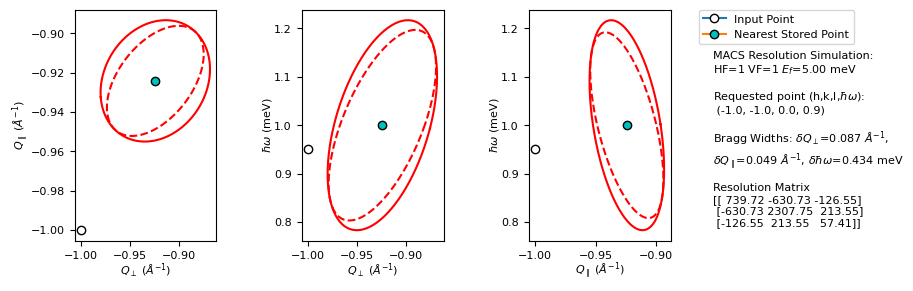

In [7]:
# A warning will be thrown if the given HKL point is out of the scattering plane, but the script will attempt to project 
# the result onto the scattering plane. 
h = -1.0
k = -1.0
l = 0.0
E = 1.0 #energy transfer, i.e. Ei=6 meV
M,M_fwhms,Q_hkw = pyMACS.scripting.macs_resfunc(h,k,l,E,macsEf,macs_instr,gen_plot=True,verbose=True,calc_mode='load_cov')

# Option 2 : Plot multiple resolution ellipsoids in the scattering plane at constant energy.

AttributeError: 'Sample' object has no attribute 'sample'

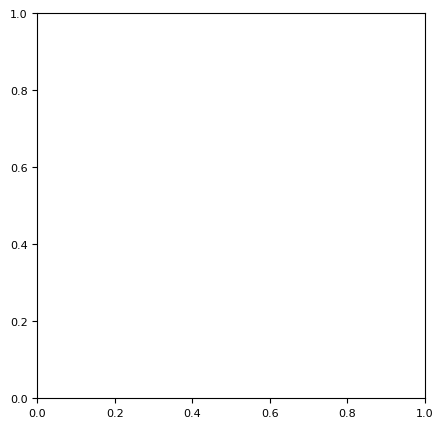

In [8]:
import numpy.linalg as la
from pyMACS.virtualMACS import VirtualMACS
import matplotlib.pyplot as plt

hpts = np.cos(np.linspace(0,np.pi/2,10))
kpts = np.sin(np.linspace(0,np.pi/2,10))
lpts = np.zeros(10)
deltaE = 3.0
fig,ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

for i,hpt in enumerate(hpts):
    qvec = hpts[i]*macs_instr.sample.astar_vec_labframe+\
            kpts[i]*macs_instr.sample.bstar_vec_labframe+\
            lpts[i]*macs_instr.sample.cstar_vec_labframe
    qxpt,qzpt = macs_instr.sample.HKL_to_QxQz(qvec[0],qvec[1],qvec[2])
    M_load,M_diag_load,Q_hkw_load = macs_instr.resmat(qvec[0],qvec[1],qvec[2],deltaE,Ef,
                                                 gen_plot=False,verbose=False)
    # The resolution matrices have been generated for each ellipsoid here - these need to be 
    # projected into the scattering plane, which is done below. 
    
    sig2hwhm = np.sqrt(2. * np.log(2.))
    sig2fwhm = 2.*sig2hwhm
    
    Qmean=np.array([qxpt,qzpt,Q_hkw_load[2]])
    
    results,Qres_proj = macs_instr.resfunc.calc_ellipses(M_load,verbose=False)
    
    ellfkt = lambda rad, rot, phi, Qmean2d : \
        np.dot(rot, np.array([ rad[0]*np.cos(phi), rad[1]*np.sin(phi) ])) + Qmean2d
    
    
    # 2d plots
    #fig = plot.figure()
    ellis = results
    num_ellis = len(ellis)
    coord_axes = [[0,1], [1,2], [0,2]]
    coord_axes = [[0,1], [0,2], [1,2]]
    
    ellplots = []
    for ellidx in [0]:
        # centre plots on zero or mean Q vector ?
        QxE = np.array([[0], [0]])
        QxE = np.array([[Qmean[coord_axes[ellidx][0]]], [Qmean[coord_axes[ellidx][1]]]])
    
        phi = np.linspace(0, 2.*np.pi, 361)
    
        ell_QxE = ellfkt(ellis[ellidx]["fwhms"]*0.5, ellis[ellidx]["rot"], phi, QxE)
        ell_QxE_proj = ellfkt(ellis[ellidx]["fwhms_proj"]*0.5, ellis[ellidx]["rot_proj"], phi, QxE)
        ellplots.append({"sliced":ell_QxE, "proj":ell_QxE_proj})
    
        ax.plot(ell_QxE[0], ell_QxE[1], c="k", linestyle="dashed")
        ax.plot(ell_QxE_proj[0], ell_QxE_proj[1], c="k", linestyle="solid")
    ax.plot(qxpt,qzpt,marker='o',mfc='k',mec='k',ms=2)

ax.set_xlabel(r"$Q_x\ (\AA^{-1}$)",labelpad=0,fontsize=8)
ax.set_ylabel(r"$Q_z\ (\AA^{-1}$)",labelpad=0,fontsize=8)
#Match limits of dave plots
ax.set_aspect(1)
#ax[1].set_aspect(1)
#ax[2].set_aspect(1)


fig.show()